# Training the model

In [1]:
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2 as cv2 # opencv computer vision library
from PIL import Image
import os
import sys

dirname = os.path.abspath(os.path.join(os.getcwd(), "..", "lib"))
sys.path.append(dirname)

from display import imshow
from vgg import VGGFeatures
from utils import preprocess, deprocess, normalize
from data import ImageFolderDataset
from DeepStyleX import DeepStyleX

## Importing the dataset and style images

In [2]:
images_dataset = ImageFolderDataset("../data/scenes", transform=preprocess)

# Style
eye_style = Image.open("../data/style/eye.jpg")
abstract_style = Image.open("../data/style/abstract1.jpg")

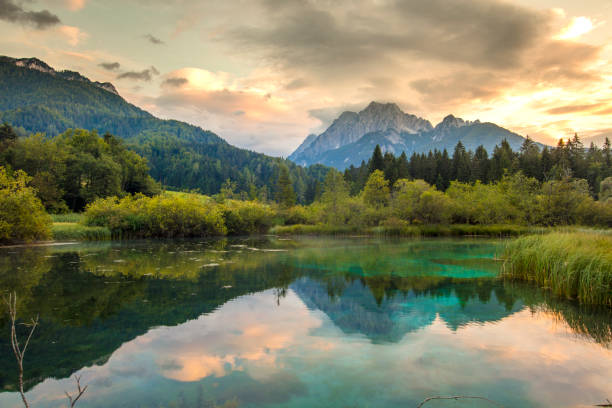

In [3]:
images_dataset.get_raw(1)

## Creating the DeepStyleX model and the feature model

In [ ]:
deep_style_model = DeepStyleX(batch_norm=True)  # Here we still use the Batch Norm, we will change it later
vgg_model = VGGFeatures(['relu2_2', 'relu3_3', 'relu4_3'])
print("Models initialized")

Models initialized


### Choosinge the style

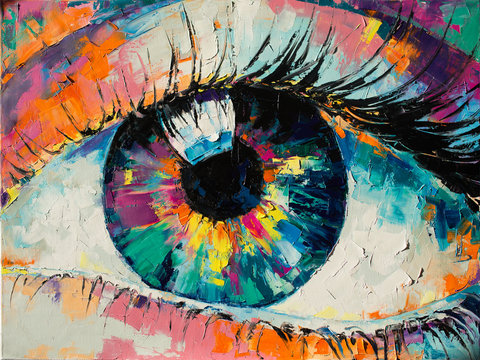

In [10]:
style_image = eye_style
feature_style = vgg_model(normalize(preprocess(style_image)))
style_image


### Testing the model

In [18]:
idx = 0

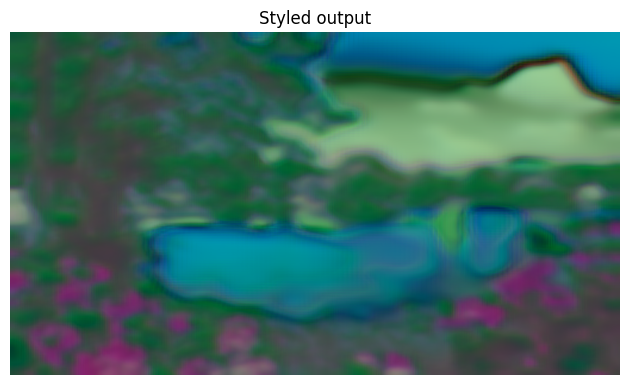

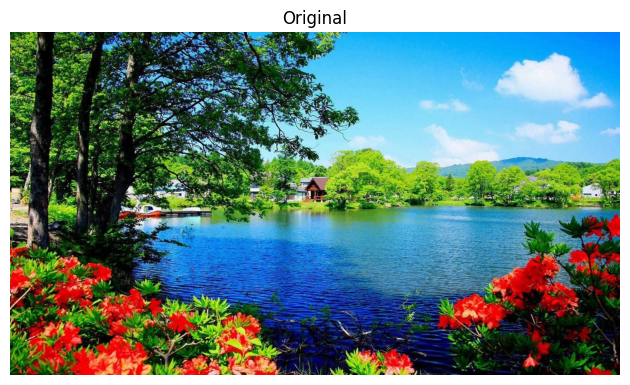

In [ ]:
deep_style_model.eval()
input_image_raw = images_dataset.get_raw(idx)

input_image = preprocess(input_image_raw).unsqueeze(0)
output = deep_style_model(input_image)
output_image = deprocess(output)
output_image = output_image.resize(input_image_raw.size)
imshow([output_image],["Styled output"])
imshow([input_image_raw],["Original"])

idx = (idx+1)%len(images_dataset)

## Training loop

In [13]:
# define the loss
def loss_function(output_features: dict, original_features: dict, style_features: dict, criterion: nn.Module, content_weight: int = 1, style_weight: int = 1):
    content_loss = 0.
    style_loss = 0.
    weights = [1, 1, 1, 1]


    content_loss += content_weight * criterion(output_features['relu2_2'], original_features['relu2_2'])

    for feature, w in zip(output_features.keys(),weights):
        style_loss += criterion(output_features[feature], style_features[feature]) * w
    style_loss *= style_weight

    return content_loss + style_loss

In [14]:
# Defining hyper parameters

content_weight = 100
style_weight = 5

batch_size = 3

learning_rate = 8e-4

dataloader = DataLoader(images_dataset, batch_size=batch_size, shuffle=True)

In [15]:
def train(model: nn.Module, epoch, lr= 1e-3):
    batch_size = dataloader.batch_size
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    criterion = nn.MSELoss()
    model.train()

    style_feature = dict()
    for feature in feature_style.keys():
        style_feature[feature] = feature_style[feature].repeat(batch_size, 1, 1, 1)

    for i in range(epoch):
        for j, batch_images in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(batch_images)
            with torch.no_grad():
                original_features = vgg_model(normalize(batch_images))
            output_features = vgg_model(normalize(output))

            loss = loss_function(output_features, original_features, style_feature, criterion, content_weight=content_weight, style_weight=style_weight)

            loss.backward()
            optimizer.step()
            print(str(i+1),'->',j,':',loss.item())

In [16]:
train(deep_style_model,15, lr=learning_rate)

1 -> 0 : 8073.1220703125
1 -> 1 : 2293.20751953125
2 -> 0 : 1719.585205078125
2 -> 1 : 1196.235107421875
3 -> 0 : 1392.1142578125
3 -> 1 : 1507.08203125
4 -> 0 : 1505.5394287109375
4 -> 1 : 962.080810546875
5 -> 0 : 1620.049560546875
5 -> 1 : 704.3297119140625
6 -> 0 : 1279.1646728515625
6 -> 1 : 944.1492919921875
7 -> 0 : 1000.330322265625
7 -> 1 : 1182.852294921875
8 -> 0 : 1279.52099609375
8 -> 1 : 868.3585205078125
9 -> 0 : 963.8831787109375
9 -> 1 : 1142.9716796875
10 -> 0 : 1219.864013671875
10 -> 1 : 857.6439208984375
11 -> 0 : 946.8643798828125
11 -> 1 : 1108.80224609375
12 -> 0 : 896.36328125
12 -> 1 : 1156.987060546875
13 -> 0 : 1132.2119140625
13 -> 1 : 886.2656860351562
14 -> 0 : 1163.150634765625
14 -> 1 : 834.5638427734375
15 -> 0 : 919.48681640625
15 -> 1 : 1050.386962890625


### We can notice that the output is styled, but in a weird way

This is a problem with our loss function, which we'll try to solve in the next notebook.